In [ ]:
# 1. Importing Libraries
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from tqdm import tqdm

# 2. Loading DataSet

df = pd.read_csv('dataset/final_dataset.csv')

# Converting labels to numeric
df['label'] = df['label'].astype(str).str.lower().map({'true': 1, 'false': 0})

print("Dataset shape:", df.shape)
print("Language distribution:\n", df['language'].value_counts())
print("Label distribution:\n", df['label'].value_counts())

# 3. Train-Test SPLIT

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(),
    df['label'].tolist(),
    test_size=0.25,
    random_state=42,
    stratify=df['language']
)

# 4. Tokenization

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=256
)

test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=256
)

# 5. Create DataSet Class

class MisinformationDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MisinformationDataset(train_encodings, train_labels)
test_dataset = MisinformationDataset(test_encodings, test_labels)

# 6. Load Model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels=2
)

model.to(device)

# 7. Training Setup

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

epochs = 3

# 8. Training Loop

print("Starting Training...\n")

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} - Average Training Loss: {avg_loss:.4f}")

print("\nTraining Complete!\n")

# 9. Evaluation

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# 10. Results

accuracy = accuracy_score(true_labels, predictions)

print("\n=== FINAL RESULTS ===")
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(true_labels, predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(true_labels, predictions))


Dataset shape: (2203, 3)
Language distribution:
 language
chinese      1224
english       435
bulgarian     348
arabic        196
Name: count, dtype: int64
Label distribution:
 label
1    1285
0     918
Name: count, dtype: int64


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-multilingual-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Starting Training...



100%|██████████| 207/207 [12:55<00:00,  3.74s/it]



Epoch 1 - Average Training Loss: 0.3812


100%|██████████| 207/207 [12:25<00:00,  3.60s/it]



Epoch 2 - Average Training Loss: 0.2763


100%|██████████| 207/207 [13:59<00:00,  4.06s/it]



Epoch 3 - Average Training Loss: 0.2556

Training Complete!



100%|██████████| 69/69 [00:47<00:00,  1.46it/s]


=== FINAL RESULTS ===
Accuracy: 0.838475499092559

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       233
           1       0.87      0.85      0.86       318

    accuracy                           0.84       551
   macro avg       0.83      0.84      0.84       551
weighted avg       0.84      0.84      0.84       551


Confusion Matrix:
[[192  41]
 [ 48 270]]


In [4]:
# model.save_pretrained("saved_model")
# tokenizer.save_pretrained("saved_model")

from transformers import BertTokenizer, BertForSequenceClassification
import torch

device = torch.device("cpu")

model = BertForSequenceClassification.from_pretrained("saved_model")
tokenizer = BertTokenizer.from_pretrained("saved_model")

model.to(device)
model.eval()

print("Model loaded successfully.")


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Model loaded successfully.


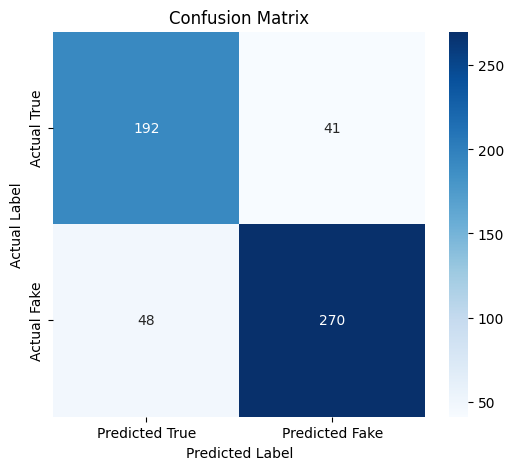

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix values
cm = np.array([[192, 41],
               [48, 270]])

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted True", "Predicted Fake"],
            yticklabels=["Actual True", "Actual Fake"])

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()


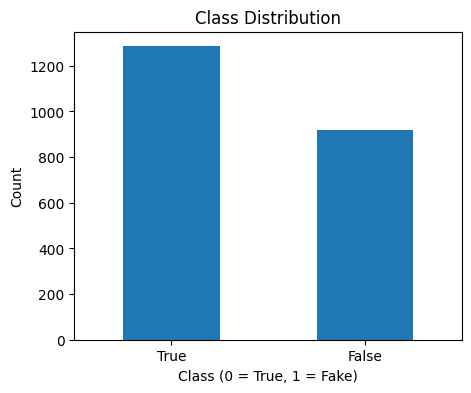

In [6]:
import pandas as pd

# Load dataset
df = pd.read_csv("Dataset/final_dataset.csv")

plt.figure(figsize=(5,4))
df['label'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class (0 = True, 1 = Fake)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


In [2]:
# Testing
text = "A viral post claims that drinking hot water can cure COVID-19, but medical experts have confirmed this is false."

inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()

print("Prediction:", "True" if prediction == 1 else "False")


Prediction: False


In [3]:
# Example text for testing
text = "Doctors say that garlic has many health benefits but it cannot cure cancer."


# Set model to evaluation mode
model.eval()

# Tokenize input
inputs = tokenizer(
    text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=256
)

# Move tensors to device (CPU/GPU)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Make prediction
with torch.no_grad():
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()

# Print result
print("Input Text:", text)
print("Prediction:", "True (Not Misinformation)" if prediction == 1 else "False (Misinformation)")



Input Text: Doctors say that garlic has many health benefits but it cannot cure cancer.
Prediction: False (Misinformation)


In [16]:
model.save_pretrained("saved_model")
tokenizer.save_pretrained("saved_model")



Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('saved_model/tokenizer_config.json', 'saved_model/tokenizer.json')

In [1]:
## Tomorrow's code

from transformers import BertTokenizer, BertForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained("saved_model")
model = BertForSequenceClassification.from_pretrained("saved_model").to(device)

print("Model loaded successfully.")


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Model loaded successfully.
